In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
def bilinear_sampler(img, coords, mode='bilinear', mask=False):
    """ Wrapper for grid_sample, uses pixel coordinates """
    H, W = img.shape[-2:]
    xgrid, ygrid = coords.split([1,1], dim=-1)
    xgrid = 2*xgrid/(W-1) - 1
    ygrid = 2*ygrid/(H-1) - 1

    grid = torch.cat([xgrid, ygrid], dim=-1)
    img = F.grid_sample(img, grid, align_corners=True)

    if mask:
        mask = (xgrid > -1) & (ygrid > -1) & (xgrid < 1) & (ygrid < 1)
        return img, mask.float()

    return img

def coords_grid(batch, ht, wd):
    coords = torch.meshgrid(torch.arange(ht), torch.arange(wd))
    coords = torch.stack(coords[::-1], dim=0).float()
    return coords[None].repeat(batch, 1, 1, 1)
def cal_corr(f0,f1):
    b,c,h,w=f0.shape
    f0=f0.view(b,c,h*w).permute(0,2,1).contiguous()
    f1=f1.view(b,c,h*w).contiguous()
    #print(f0.shape,f1.shape)
    mp=torch.bmm(f0,f1)/c
    mp=mp.view(b,h*w,h,w)
    return mp

class CorrBlock(nn.Module):
    def __init__(self,num_levels=2, radius=3,input_dim=64):
        super(CorrBlock, self).__init__()
        self.num_levels = num_levels
        self.radius = radius
        self.fc1=nn.Conv2d(input_dim,input_dim//4,kernel_size=1,bias=False)#nn.Linear(input_dim,input_dim//4,bias=False)
        self.fc0=nn.Conv2d(input_dim,input_dim//4,kernel_size=1,bias=False)
    def forward(self,x):
        self.corr_pyramid = []
        device=x.device
        #print('x:de:',x.device)
        r=self.radius
        x=x.permute(0,2,1,3,4).contiguous()
        # x:b,t,c,h,w
        f0=x[:,:-1].clone()
        f1=x[:,1:].clone()
        b,t,c,h,w=f0.shape
        f0=f0.view(b*t,c,h,w)
        f1=f1.view(b*t,c,h,w)
        f0=self.fc0(f0)
        f1=self.fc1(f1)
        bt,c,h,w=f0.shape # 16 11

        f0=f0.view(b*t,c,h,w)
        f1=f1.view(b*t,c,h,w)
        
        b,c,h,w=f0.shape
        
        
        coords = coords_grid(b, h, w).to(device)
        coords = coords.permute(0, 2, 3, 1)
        
        
        corr=cal_corr(f0,f1)
        corr_rt=corr.clone()
        #print('corr:de:',corr.device)
        #print('coords:de:',coords.device)
        corr=corr.reshape(b*h*w, 1, h, w)
        self.corr_pyramid.append(corr)
        for i in range(self.num_levels-1):
            corr = F.avg_pool2d(corr, 2, stride=2)
            self.corr_pyramid.append(corr)
        out_pyramid = []
        sampled_corr=[]
        for i in range(self.num_levels):
            
            corr=self.corr_pyramid[i]

            #print(coords.shape)
            dx = torch.linspace(-r, r, 2*r+1)
            dy = torch.linspace(-r, r, 2*r+1)
            #print('dx,dy.shape',dx.shape)
            delta = torch.stack(torch.meshgrid(dy, dx), axis=-1).to(device)
            #print('delata:',delta.device)
            #print(delta)
            centroid_lvl = coords.reshape(b*h*w, 1, 1, 2) / (2**i)
            #print(centroid_lvl)
            delta_lvl = delta.view(1, 2*r+1, 2*r+1, 2)
            #print(delta_lvl)
            coords_lvl = centroid_lvl + delta_lvl
            #print(centroid_lvl.shape,delta_lvl.shape)
            #print(coords_lvl.shape)
            #print('de pair:',corr.device,coords_lvl.device)
            corr = bilinear_sampler(corr, coords_lvl)
            sampled_corr.append(corr)
            #print('corr:',corr.shape)
            corr = corr.view(b, h, w, -1)
            out_pyramid.append(corr)
            
        out_fea=torch.cat(out_pyramid,3)
        b,h,w,c=out_fea.shape
        out_fea=out_fea.view(b//t,t,h,w,c)
        return out_fea.permute(0, 4, 1, 2, 3).contiguous().float(),corr_rt,sampled_corr # b c t h w

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import math
from functools import partial
from torch.nn.parameter import Parameter
import torch.nn as nn

def gem(x, p=6.5, eps=1e-6):
    # print('x-',x.shape)
    # print('xpow-',x.clamp(min=eps).pow(p).shape)
    # print(F.avg_pool2d(x.clamp(min=eps).pow(p), (1, x.size(-1))).shape)
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (1, x.size(-1))).pow(1./p)

class GeM(nn.Module):

    def __init__(self, p=6.5, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        # print('p-',self.p)
        return gem(x, p=self.p, eps=self.eps)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

def gem1(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM_1(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM_1,self).__init__()
        #self.p = Parameter(torch.ones(1)*p)
        self.p=1
        self.eps = eps
    def forward(self, x):
        return gem1(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p) + ', ' + 'eps=' + str(self.eps) + ')'


    
class Temporal(nn.Module):
    def __init__(self, inplanes, planes, bias=False, **kwargs):
        super(Temporal, self).__init__()

    def forward(self, x):
        
        out = torch.max(x, 2)[0]
        return out


class BasicConv3d_p(nn.Module):
    def __init__(self, inplanes, planes, kernel=3, bias=False, p=2, FM=False, **kwargs):
        super(BasicConv3d_p, self).__init__()
        self.p = p
        self.fm = FM
        self.convdl = nn.Conv3d(inplanes, planes, kernel_size=(kernel, kernel, kernel), bias=bias, padding=((kernel-1)//2, (kernel-1)//2, (kernel-1)//2))
        self.convdg = nn.Conv3d(inplanes, planes, kernel_size=(kernel, kernel, kernel), bias=bias, padding=((kernel-1)//2, (kernel-1)//2, (kernel-1)//2))
    def forward(self, x):
        n, c, t, h, w = x.size()
        scale = h//self.p
        # print('p-',x.shape,n, c, t, h, w,'scale-',scale)
        feature = list()
        for i in range(self.p):
            temp = self.convdl(x[:,:,:,i*scale:(i+1)*scale,:])
            # print(temp.shape,i*scale,(i+1)*scale)
            feature.append(temp)

        outl = torch.cat(feature, 3)
        # print('outl-',outl.shape)
        outl = F.leaky_relu(outl, inplace=True)

        outg = self.convdg(x)
        outg = F.leaky_relu(outg, inplace=True)
        # print('outg-',outg.shape)
        if not self.fm:
            # print('1-1')
            out = outg + outl
        else:
            # print('1-2')
            out = torch.cat((outg, outl), dim=3)
        return out


class BasicConv3d(nn.Module):
    def __init__(self, inplanes, planes, dilation=1, bias=False, **kwargs):
        super(BasicConv3d, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=(3, 3, 3), bias=bias, dilation=(dilation, 1, 1), padding=(dilation, 1, 1))

    def forward(self, x):
        out = self.conv1(x)
        out = F.leaky_relu(out, inplace=True)
        return out

class LocaltemporalAG(nn.Module):
    def __init__(self, inplanes, planes, dilation=1, bias=False, **kwargs):
        super(LocaltemporalAG, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=(3, 1, 1), stride=(3,1,1), bias=bias,padding=(0, 0, 0))

    def forward(self, x):
        out1 = self.conv1(x)
        out = F.leaky_relu(out1, inplace=True)
        return out

class LocaltemporalAG33(nn.Module):
    def __init__(self, inplanes, planes, dilation=1, bias=False, **kwargs):
        super(LocaltemporalAG33, self).__init__()
        self.conv1 = nn.Conv3d(inplanes, planes, kernel_size=(3, 3, 3), stride=(3,1,1), bias=bias,padding=(0, 1, 1))

    def forward(self, x):
        out1 = self.conv1(x)
        out = F.leaky_relu(out1, inplace=True)
        return out


class C3D_VGG_angle_emb_motion(nn.Module):

    def __init__(self, num_classes=74):
        super(C3D_VGG_angle_emb_motion, self).__init__()
        _set_channels = [32, 64, 128, 256]
        self.view_nums=11
        self.radius=3
        # --------------------------------  2d gei---------------------------------------
        self.conv2dlayer1a = BasicConv3d(1, _set_channels[0], kernel=3)
        # self.conv2dlayer1b = BasicConv3d(_set_channels[0], _set_channels[0])
        self.pool2d1 = LocaltemporalAG(_set_channels[0], _set_channels[0])


        self.conv2dlayer2a = BasicConv3d_p(_set_channels[0], _set_channels[1])
        # self.conv2dlayer2b = BasicConv3d(_set_channels[1], _set_channels[1])
        self.pool2d2 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2dlayer25a_3d = BasicConv3d_p(_set_channels[1], _set_channels[2])
        self.conv2dlayer25b_3d = BasicConv3d_p(_set_channels[2], _set_channels[2],FM=True)

        #self.conv2dlayer3a_3d = BasicConv3d_p(_set_channels[2], _set_channels[3])
        #self.conv2dlayer3b_3d = BasicConv3d_p(_set_channels[3], _set_channels[3], FM=True)

        self.fpb3d = Temporal(_set_channels[2], _set_channels[2])

        self.Gem = GeM()
        self.avgpool = GeM_1()
        self.cls=nn.Linear(in_features=_set_channels[2], out_features=11)
        '''
        self.trans_view=nn.ParameterList([
            nn.Parameter(
                nn.init.xavier_uniform_(
                    torch.zeros(64, 128, 256)))]*11)
        '''
        self.view_embedding_64 = nn.Parameter(torch.randn(self.view_nums,_set_channels[0],1))

        self.bin_numgl = [32*2]
        self.fc_bin = nn.Parameter(
                nn.init.xavier_uniform_(
                    torch.zeros(sum(self.bin_numgl), _set_channels[2]+_set_channels[0], _set_channels[3])))
        
        
        self.view_embedding_64_motion = nn.Parameter(torch.randn(self.view_nums,_set_channels[0],1))

        self.bin_numgl_motion = [4]
        self.fc_bin_motion = nn.Parameter(
                nn.init.xavier_uniform_(
                    torch.zeros(sum(self.bin_numgl_motion), _set_channels[2]+_set_channels[0], _set_channels[3])))
                    

        self.motion_extract=CorrBlock(num_levels=1, radius=self.radius)
        self.motion_conv1=BasicConv3d(1*(self.radius*2+1)**2,_set_channels[2],kernel_size=3)
        #self.motion_conv2=BasicConv3d(_set_channels[2], _set_channels[2],kernel_size=3)
        self.pool_motion=nn.AdaptiveAvgPool2d((1,1))




        self.relu = nn.ReLU()
        for m in self.modules():
            # print('---')
            if isinstance(m, (nn.Conv3d, nn.Conv2d, nn.Conv1d)):
                nn.init.xavier_uniform_(m.weight.data)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight.data)
                nn.init.constant_(m.bias.data, 0.0)
            elif isinstance(m, (nn.BatchNorm3d, nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0.0)

    def forward(self, x):
        # print(x.shape)
        x=x.permute(0,2,1,3,4).contiguous()
        n, c, t, h, w = x.size()
        if t == 1:
            x = x.repeat(1, 1, 3, 1, 1)
        elif t == 2:
            x = x.repeat(1, 1, 2, 1, 1)
        elif t == 3:
            x = torch.cat((x,x[:,:,0:1,:,:]),dim=2)
        # print(x.shape)

        # ----------------2d--------------------
        x2d = self.conv2dlayer1a(x)
        # x2d = self.conv2dlayer1b(x2d)
        x2d = self.pool2d1(x2d)
        #print('pool2d1-',x2d.shape)
        x2d = self.conv2dlayer2a(x2d)
        # x2d = self.conv2dlayer2b(x2d)
        x2d = self.pool2d2(x2d)
        #print('pool2d2-',x2d.shape)


        x2d_motion=x2d.clone()
        x2d_motion_rt=x2d_motion.clone()
        b,c,t,h,w=x2d_motion.shape
        x2d_motion=x2d_motion.view(b*c,t,h,w)
        x2d_motion=F.avg_pool2d(x2d_motion, kernel_size=(2,2))
        x2d_motion=x2d_motion.view(b,c,t,h//2,w//2)
        rt_x2d_notion=x2d_motion.clone()
        x2d_motion,corr_rt,sampled_corr=self.motion_extract(x2d_motion) # b (2*r+1)**2*2 t 16 11
        x2d_motion=self.motion_conv1(x2d_motion) 
        #x2d_motion=self.motion_conv2(x2d_motion) # b 256 t//3 16 11
        b,c,t,h,w=x2d_motion.shape
        x2d_motion=x2d_motion.permute(0,1,3,4,2).contiguous()
        x2d_motion=x2d_motion.view(b,c,h,w*t)

        x2d = self.conv2dlayer25a_3d(x2d)
        x2d = self.conv2dlayer25b_3d(x2d) # b t 256 64 22


        x2db3d = self.fpb3d(x2d)
        #print('4:',x2db3d.shape)
        n, c2d, _, _ = x2db3d.size()
        x_feat=self.avgpool(x2db3d)
        x_feat=x_feat.view(n,c2d)
        angle_probe=self.cls(x_feat) # n 11
        _,angle= torch.max(angle_probe, 1)
        
        
        
        n,c2d,hh,ww=x2d_motion.shape
        feature_motion=[]
        for num_bin in self.bin_numgl_motion:
            z = x2d_motion.view(n, c2d, num_bin, hh//num_bin,ww).contiguous()
            #z = x2d_motion.view(n, c2d, num_bin, -1).contiguous()
            # z1 = z.mean(3) + z.max(3)[0]
            # print('z1-',z1.shape)
            #z2 = self.Gem(z).squeeze(-1)
            z=self.pool_motion(z)
            #print(z.shape)
            z2=torch.cat([z.view(n, c2d, num_bin),self.view_embedding_64_motion[angle].expand(-1,-1,num_bin)],1)
            # print('z2-',z2.shape)
            feature_motion.append(z2)
        feature_motion = torch.cat(feature_motion, 2).permute(2, 0, 1).contiguous() #  8 n 256
        #print('feature',feature.shape)
        feature_motion = feature_motion.matmul(self.fc_bin_motion) # 8 n 256
        feature_motion = feature_motion.permute(1, 2, 0).contiguous()
        #print('3:',x2d.shape)
        #x2da3d = self.conv2dlayer3a_3d(x2d)
        # print('conv2dlayer3a_3d-',x2da3d.shape)
        #x2db3d = self.conv2dlayer3b_3d(x2da3d)
        # print('conv2dlayer3b_3d-',x2db3d.shape)
        
        #print('x2db-',x2db3d.shape)

        # xgem = self.Gem(x2db3d)
        # print('xgem-',xgem.shape)

        _, c2d, _, _ = x2db3d.size()

        feature = list()
        for num_bin in self.bin_numgl:
            z = x2db3d.view(n, c2d, num_bin, -1).contiguous()
            # z1 = z.mean(3) + z.max(3)[0]
            # print('z1-',z1.shape)
            #z2 = self.Gem(z).squeeze(-1)
            z2=torch.cat((self.Gem(z).squeeze(-1),self.view_embedding_64[angle].expand(-1,-1,num_bin)),1)
            # print('z2-',z2.shape)
            feature.append(z2)
        feature = torch.cat(feature, 2).permute(2, 0, 1).contiguous() #  64 n 256
        #print('feature',feature.shape)
        feature = feature.matmul(self.fc_bin) # 64 n 256
        feature = feature.permute(1, 2, 0).contiguous()
        feature=torch.cat([feature_motion,feature],2)
        #feature = feature.permute(1, 2, 0).contiguous() #n 256 64
        #feature = feature.permute(1, 0, 2).contiguous()#n 64 256 
        '''
        feature_rt=[]
        for j in range(feature.shape[0]):
            #print(feature[j].shape)
            feature_now=((feature[j].unsqueeze(1)).bmm(self.trans_view[angle[j]])).squeeze(1) # 64*256
            feature_rt.append(feature_now)
        # print('feature',feature.shape)
        feature = torch.cat([x.unsqueeze(0) for x in feature_rt]) # n 64 256
        feature = feature.permute(0, 2, 1).contiguous()
        #print(feature.shape)
        '''
        return feature,angle_probe,corr_rt,x2d_motion_rt,sampled_corr,rt_x2d_notion

import os
os.environ["CUDA_VISIBLE_DEVICES"]='8'
net=C3D_VGG_angle_emb_motion()
net=net.cuda()
net=nn.DataParallel(net)

net.eval()

DataParallel(
  (module): C3D_VGG_angle_emb_motion(
    (conv2dlayer1a): BasicConv3d(
      (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (pool2d1): LocaltemporalAG(
      (conv1): Conv3d(32, 32, kernel_size=(3, 1, 1), stride=(3, 1, 1), bias=False)
    )
    (conv2dlayer2a): BasicConv3d_p(
      (convdl): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (convdg): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (pool2d2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2dlayer25a_3d): BasicConv3d_p(
      (convdl): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (convdg): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (conv2dlayer25b_3d): BasicConv3d_p(
      (convdl): Conv3d(128, 128, kerne

In [3]:
stat=torch.load('/mnt/data/ctr/gait_trans/\vggc3d_em_motionmean_early0_qk_mean_03ce_r3_32em/checkpoint/VGG3D_veiwem_motion/VGG3D_veiwem_motion_CASIA-B_73_False_0.2_320_full_30-60000-encoder.ptm')
#stat=torch.load('/mnt/data/ctr/gait_trans/vggc3d_em_motion_early_noqk_mean_03ce_le1_r3_32em_lt/checkpoint/VGG3D_veiwem_motion/VGG3D_veiwem_motion_CASIA-B_73_False_0.2_224_full_30-42000-encoder.ptm')

net.load_state_dict(stat)


<All keys matched successfully>

In [156]:
import numpy as np
import cv2
import xarray as xr
dir='/mnt/data/ctr/gait/CASIA_B/010/nm-01/090/'
img_list=os.listdir(dir)
def img2xarray(flie_path):
    imgs = sorted(list(os.listdir(flie_path)))

    frame_list = [np.reshape(
        cv2.imread(os.path.join(flie_path, _img_path)),
        [64, 64, -1])[:, :, 0]
                  for _img_path in imgs
                  if os.path.isfile(os.path.join(flie_path, _img_path))]
    num_list = list(range(len(frame_list)))
    data_dict = xr.DataArray(
        frame_list,
        coords={'frame': num_list},
        dims=['frame', 'img_y', 'img_x'],
    )
    return data_dict
data=img2xarray(dir)[:, :, 10:-10].astype('float32') / 255.0
print(type(data))
data=[feature.values for feature in data]
data_ori=data
data=torch.tensor(data)
data=data[:30].unsqueeze(0) # 1 30 64 44
data=data.unsqueeze(2)
print(data.shape)
data=data.cuda()
feature,angle_probe,corr_rt,x2d_motion_rt,sampled_corr,rt_x2d_notion=net(data)

<class 'xarray.core.dataarray.DataArray'>
torch.Size([1, 30, 1, 64, 44])


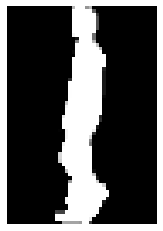

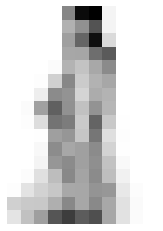

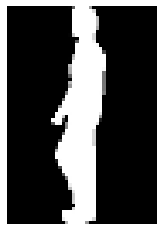

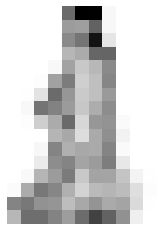

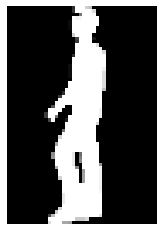

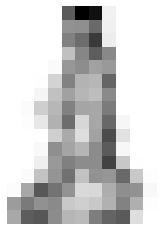

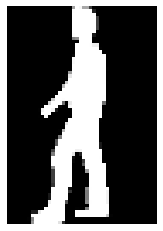

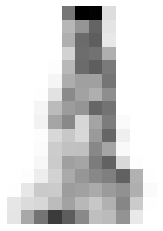

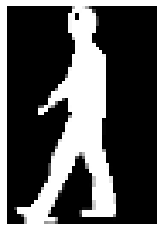

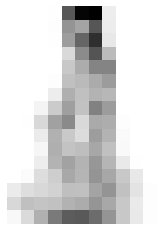

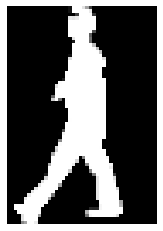

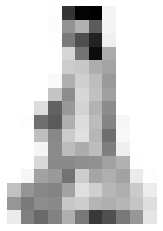

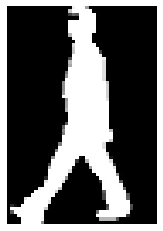

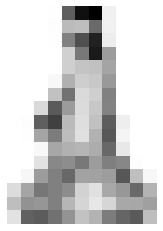

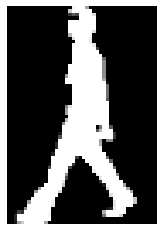

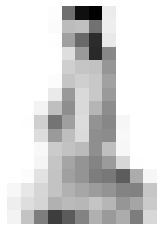

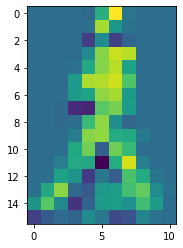

torch.Size([10, 16, 11])


<Figure size 432x288 with 0 Axes>

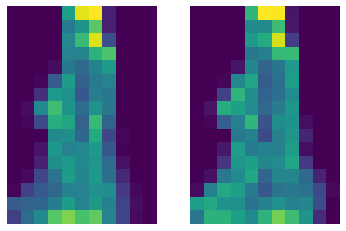

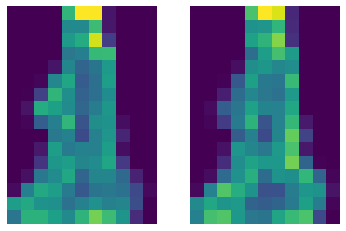

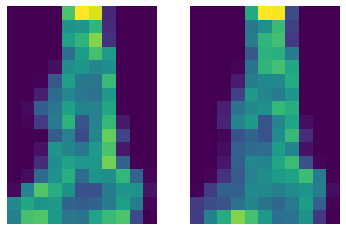

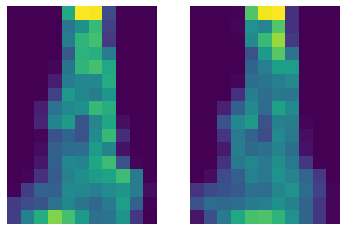

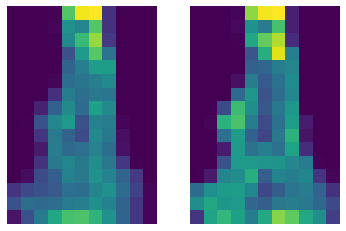

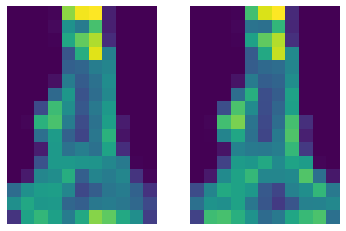

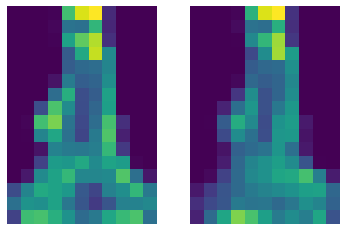

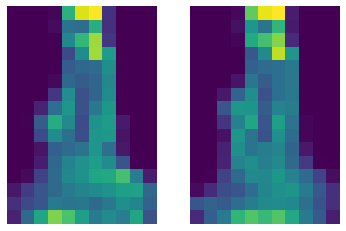

In [157]:
import matplotlib.pyplot as plt


for i in range(8):
    plt.figure()
    plt.imshow(1-data_ori[0+1*i],cmap='Greys')
    plt.axis('off')
    plt.show()
    plt.figure()
    plt.imshow(rt_x2d_notion[0].mean(0).detach().cpu()[i],cmap='Greys')
    plt.axis('off')

plt.figure()
#print(corr_rt[0][3*(11-1)+0].shape)
att=corr_rt[0][13*(11-1)+5]#corr_rt[0].view(176,176)#corr_rt[6][11*(11-1)+10]#.view(176,176)
plt.imshow(att.detach().cpu().numpy())
plt.show()
print(rt_x2d_notion[0].mean(0).shape)
plt.figure()
for i in range(8):
    plt.figure()
    
    ax=plt.subplot(1, 2, 1)
    plt.imshow(rt_x2d_notion[0].mean(0).detach().cpu()[i])
    plt.axis('off')
    ax=plt.subplot(1,2,2)
    
    plt.imshow(rt_x2d_notion[0].mean(0).detach().cpu()[i+1])
    plt.axis('off')
    plt.show()
    

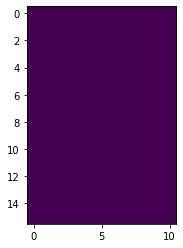

In [158]:
'''
for i in range(12):
    plt.figure()
    plt.imshow(1-data_ori[i],cmap='Greys')
    plt.axis('off')
    plt.show()
'''

plt.figure()
#print(corr_rt[0][3*(11-1)+0].shape)
att=corr_rt[6][11*(5-1)+2]#corr_rt[0].view(176,176)#corr_rt[6][11*(11-1)+10]#.view(176,176)
plt.imshow(att.detach().cpu().numpy())
plt.show()

In [212]:
print(sampled_corr[0].shape)
mo=sampled_corr[0].view(9,16,11,7,7)
mo=mo.detach().cpu().numpy()

torch.Size([1584, 1, 7, 7])


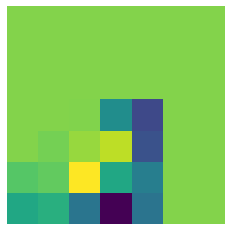

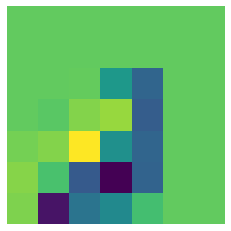

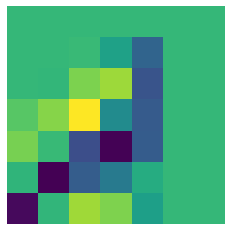

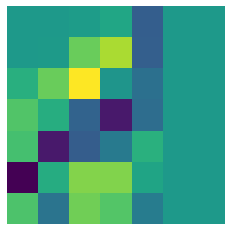

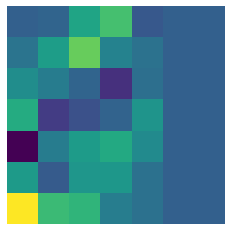

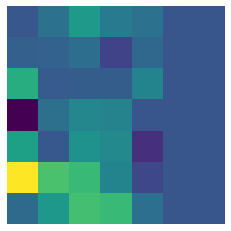

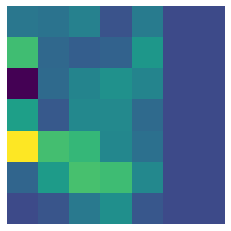

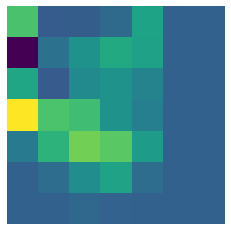

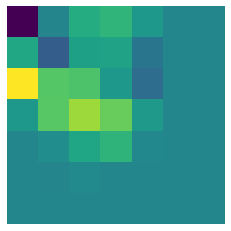

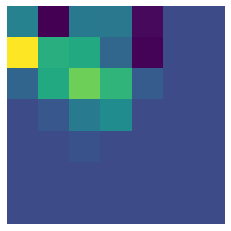

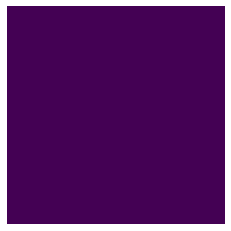

In [239]:
for i in range(11):
    plt.figure()
    plt.imshow(mo[0][14][i])
    plt.axis('off')
    plt.show()

In [136]:
mo_field_0=np.zeros((9,16,11,1))
mo_field_1=np.zeros((9,16,11,1))
print(mo.shape) # 9 16 11 7 7
print(np.argmax(mo[0][5][5].mean(1),0),np.argmax(mo[0][5][5].mean(0),0))
print(np.unravel_index(np.argmax(mo[0][5][5]),np.array(mo[0][5][5]).shape))
for i in range(9):
    for j in range(16):
        for k in range(11):
            #ind=np.unravel_index(np.argmax(mo[i][j][k]),np.array(mo[i][j][k]).shape)
            rt=0
            for ii in range(7):
                for jj in range(7):
                    rt=rt+(ii-3.5)*mo[i][j][k][ii][jj] 
                mo_field_0[i,j,k]=rt/7
            rt=0
            for ii in range(7):
                for jj in range(7):
                    rt=rt+(ii-3.5)*mo[i][j][k][jj][ii] 
                mo_field_1[i,j,k]=rt/7
            #mo_field[i,j,k][2]=(((ind[0]-3)/7)**2+((ind[1]-3)/7)**2)**(1/2)
print('ok')

(9, 16, 11, 7, 7)
4 5
(5, 1)
ok


In [232]:
x=np.zeros((9,16,11,7*50,7*50))
mo2_field_0=np.zeros((9,16,11,1))
mo2_field_1=np.zeros((9,16,11,1))
print(mo.shape) # 9 16 11 7 7
print(np.argmax(mo[0][5][5].mean(1),0),np.argmax(mo[0][5][5].mean(0),0))
print(np.unravel_index(np.argmax(mo[0][5][5]),np.array(mo[0][5][5]).shape))
for i in range(9):
    for j in range(16):
        for k in range(11):
            ind=np.unravel_index(np.argmax(mo[i][j][k]),np.array(mo[i][j][k]).shape)
            if i==0 and j==5:
                print(ind)
            rt=0
            '''
            for ii in range(7):
                for jj in range(7):
                    rt=rt+(ii-3.5)*(mo[i][j][k][ii][jj]/(mo[i][j][k].sum()+1e-6)) 
            '''
            mo2_field_0[i,j,k]=ind[0]-3
            rt=0
            '''
            for ii in range(7):
                for jj in range(7):
                    rt=rt+(ii-3.5)*mo[i][j][k][jj][ii]/(mo[i][j][k].sum()+1e-6)
            '''
            mo2_field_1[i,j,k]=ind[1]-3
            #mo_field[i,j,k][2]=(((ind[0]-3)/7)**2+((ind[1]-3)/7)**2)**(1/2)
            pt1 = (int(3.5*50),int(3.5*50))
            
            pt2 = (int(50*(3+mo2_field_1[i,j,k])), int(50*(3+mo2_field_0[i,j,k])))
            cv2.arrowedLine(x[i,j,k], pt1, pt2, (255,255,255), 20,tipLength=0.3)
print('ok')
print(mo2_field_0[0,5,0])

(9, 16, 11, 7, 7)
4 3
(5, 1)
(0, 0)
(0, 0)
(6, 3)
(6, 3)
(5, 3)
(5, 1)
(4, 1)
(3, 1)
(0, 0)
(0, 0)
(0, 0)
ok
[-3.]


[2.] [-1.]


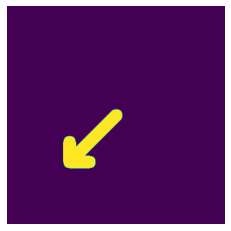

[1.] [-1.]


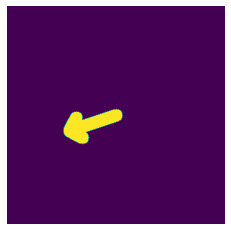

[0.] [-1.]


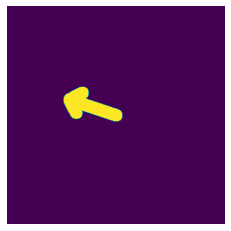

[-1.] [-1.]


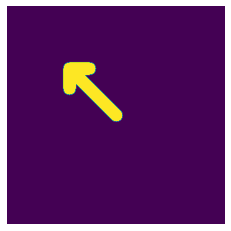

[3.] [-3.]


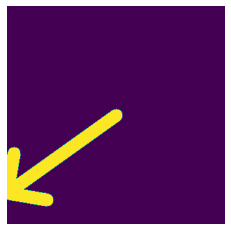

[2.] [-3.]


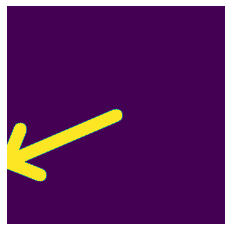

[1.] [-3.]


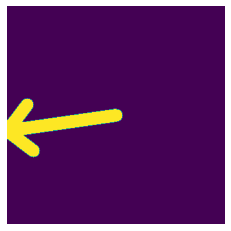

[0.] [-3.]


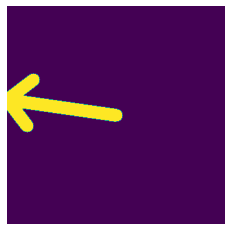

[-1.] [-3.]


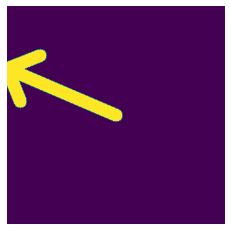

[-2.] [-3.]


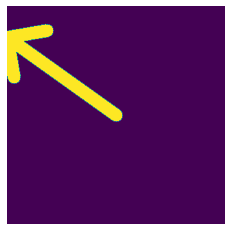

[-3.] [-3.]


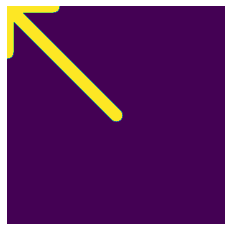

In [241]:
for j in range(11):
    plt.figure()
    print(mo2_field_0[0,14,j],mo2_field_1[0,14,j])
    plt.axis('off')
    plt.imshow(x[0,14,j])
    plt.show()

(16, 11, 3)


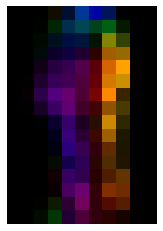

(16, 11, 3)


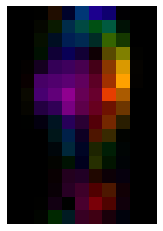

(16, 11, 3)


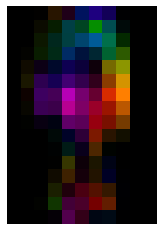

(16, 11, 3)


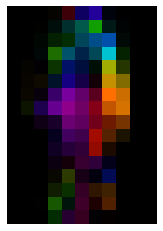

(16, 11, 3)


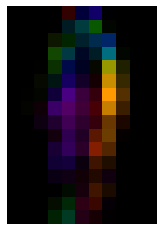

(16, 11, 3)


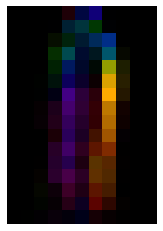

(16, 11, 3)


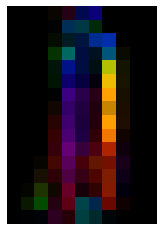

(16, 11, 3)


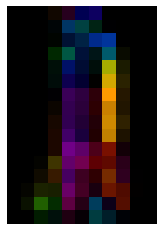

(16, 11, 3)


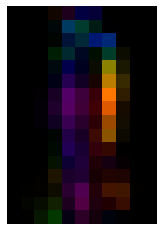

In [109]:
for i in range(9):
    
    hsv=np.zeros((16,11,3))
    hsv[...,1] = 255.0
    #flow = cv2.calcOpticalFlowFarneback(mo_field_0[1][:,:,0],mo_field_1[1][:,:,0], None, 0.5, 3, 10, 3, 5, 1.2, 0)
    #print(flow.shape)


    mag, ang = cv2.cartToPolar(mo_field_0[i][:,:,0], mo_field_1[i][:,:,0])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    print(hsv.shape)
    hsv=hsv.astype(np.uint8)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    plt.figure()
    #ax3=plt.subplot(1,3,3)
    plt.imshow(bgr)
    plt.axis('off')
    plt.show()

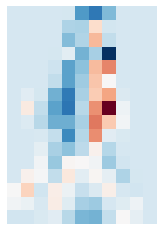

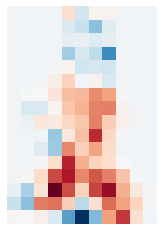

(16, 11, 3)


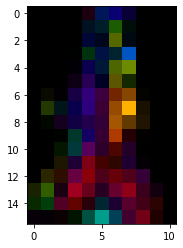

In [62]:


plt.figure()
plt.imshow(mo_field_0[1],cmap='RdBu')
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(mo_field_1[1],cmap='RdBu')
plt.axis('off')
plt.show()

hsv=np.zeros((16,11,3))
hsv[...,1] = 255.0
#flow = cv2.calcOpticalFlowFarneback(mo_field_0[1][:,:,0],mo_field_1[1][:,:,0], None, 0.5, 3, 10, 3, 5, 1.2, 0)
#print(flow.shape)


mag, ang = cv2.cartToPolar(mo_field_0[1][:,:,0], mo_field_1[1][:,:,0])
hsv[...,0] = ang*180/np.pi/2
hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
print(hsv.shape)
hsv=hsv.astype(np.uint8)
bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

plt.figure()
#ax3=plt.subplot(1,3,3)
plt.imshow(bgr)
plt.show()

<Figure size 432x288 with 0 Axes>

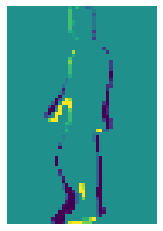

(64, 44, 2)
(64, 44, 3)


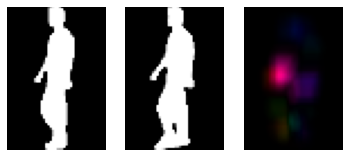

<Figure size 432x288 with 0 Axes>

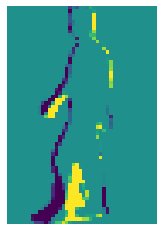

(64, 44, 2)
(64, 44, 3)


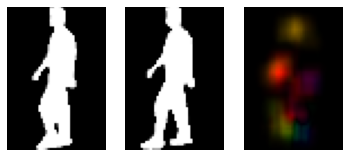

<Figure size 432x288 with 0 Axes>

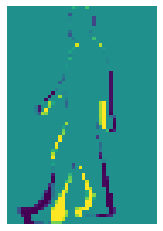

(64, 44, 2)
(64, 44, 3)


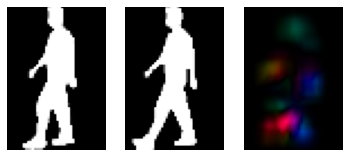

<Figure size 432x288 with 0 Axes>

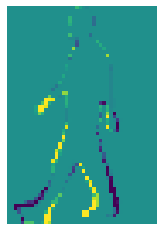

(64, 44, 2)
(64, 44, 3)


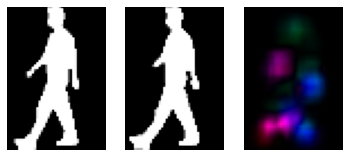

<Figure size 432x288 with 0 Axes>

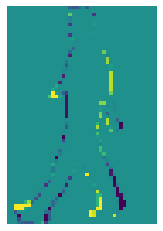

(64, 44, 2)
(64, 44, 3)


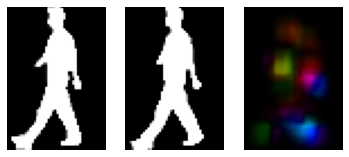

<Figure size 432x288 with 0 Axes>

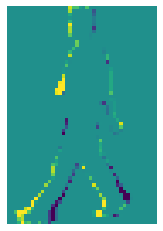

(64, 44, 2)
(64, 44, 3)


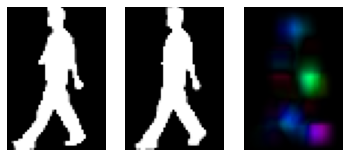

<Figure size 432x288 with 0 Axes>

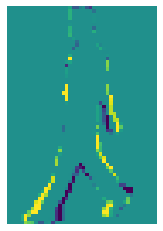

(64, 44, 2)
(64, 44, 3)


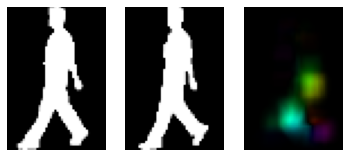

<Figure size 432x288 with 0 Axes>

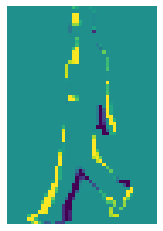

(64, 44, 2)
(64, 44, 3)


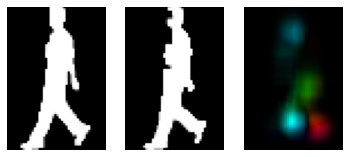

<Figure size 432x288 with 0 Axes>

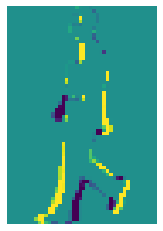

(64, 44, 2)
(64, 44, 3)


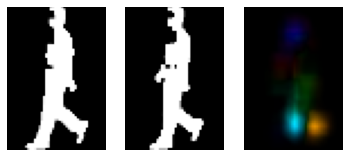

In [13]:

for i in range(1,10):
    plt.figure()
    
    
    i1=1-data_ori[i]
    i2=1-data_ori[i+1]
    plt.figure()
    plt.axis('off')
    plt.imshow(i2-i1)
    plt.show()
    ax1 = plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.imshow(i1,cmap='Greys')
    ax2=plt.subplot(1,3,2)
    plt.axis('off')
    plt.imshow(i2,cmap='Greys')
    
    hsv=np.zeros((64,44,3))
    hsv[...,1] = 255.0
    flow = cv2.calcOpticalFlowFarneback(i1,i2, None, 0.5, 3, 10, 3, 5, 1.2, 0)
    print(flow.shape)


    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    print(hsv.shape)
    hsv=hsv.astype(np.uint8)
    bgr = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    #plt.figure()
    ax3=plt.subplot(1,3,3)
    plt.axis('off')
    plt.imshow(bgr)
    plt.show()

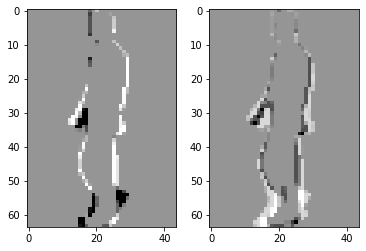

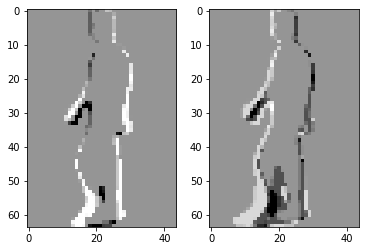

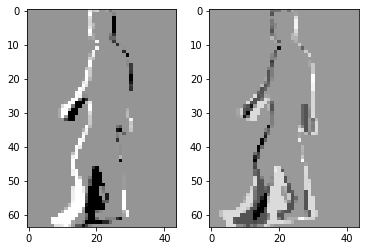

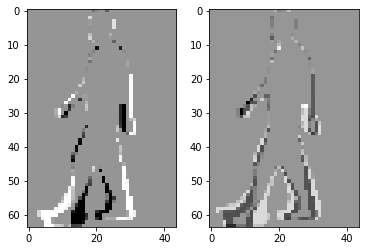

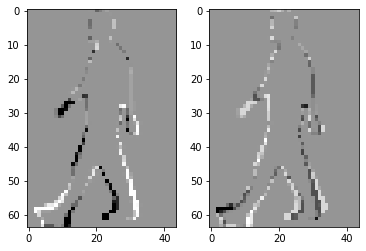

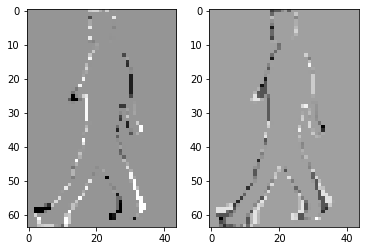

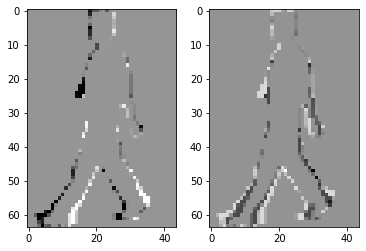

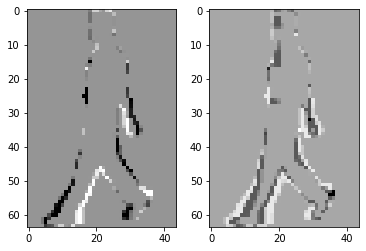

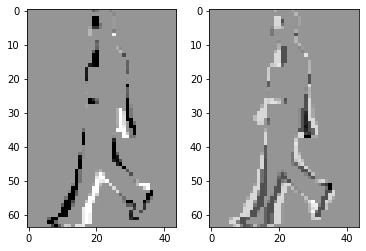

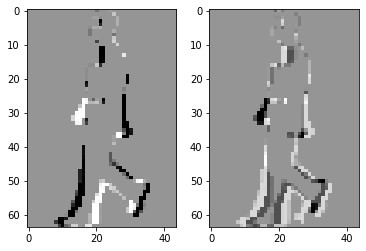

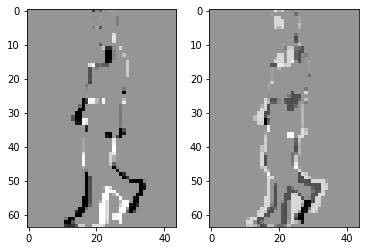

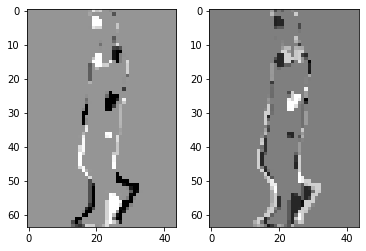

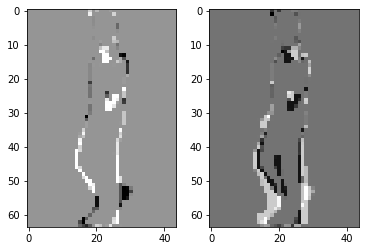

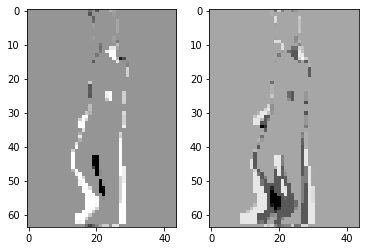

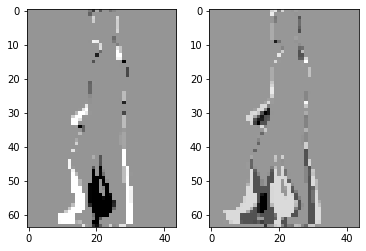

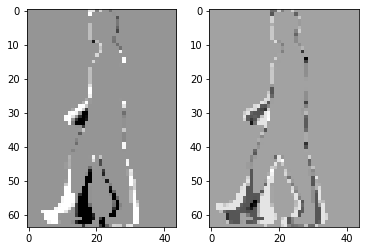

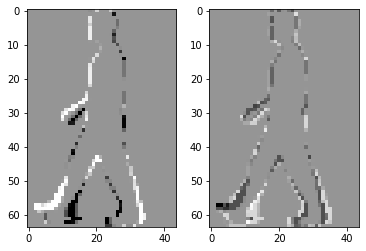

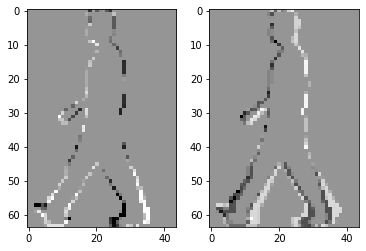

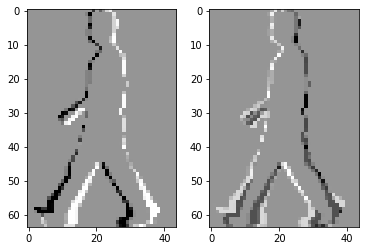

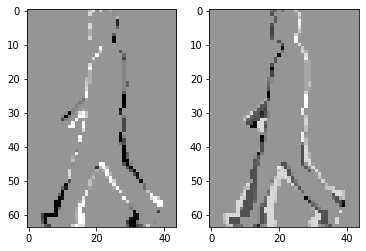

In [14]:
for i in range(20):
    plt.figure()
    i1=1-data_ori[i]
    i2=1-data_ori[i+1]
    i3=1-data_ori[i+2]
    ax1=plt.subplot(1,2,1)
    plt.imshow(i2-i1,cmap='Greys')
    ax2=plt.subplot(1,2,2)
    plt.imshow((-2*i2+i1+i3)/2,cmap='Greys')
    plt.show()